## Konvergenssi-plotit ja simuloitujen mallien lataus

In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
import sys
from prophet.python import fbprophet
from prophet.python.fbprophet import models
from prophet.python.fbprophet import plot
from prophet.python.fbprophet import diagnostics
from prophet.python.fbprophet.serialize import model_to_json, model_from_json
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pkg_resources
import os
from pathlib import Path
import numpy as np
import scipy
from copy import deepcopy
import tqdm

import metrics_refactored

from make_datasets import data, datasets, format_for_prophet, dataset_generator

In [27]:
big_fit = pd.read_csv('../big_fit.csv')
big_fit

,Unnamed: 0,metric_name,value,dataset_name,model_name,aux
0,0,AIC,-394.399183,aggregated_A,m1,NaN
1,1,DIC,-438.827668,aggregated_A,m1,{'p_dic': 24.691509379706474}
2,2,WAIC,-15.901158,aggregated_A,m1,{'p_waic': 236.24901258297655}
3,3,10-fold_cv,205.388146,aggregated_A,m1,"{'lppd_loo_cv': 202.6521732975443, 'bias': 2.7..."
4,4,default_cv,0.033642,aggregated_A,m1,ds yhat yhat_lower y...
...,...,...,...,...,...,...
295,295,AIC,-722.696491,single_store_38_of_C,m5,NaN
296,296,DIC,-721.187403,single_store_38_of_C,m5,{'p_dic': 4.73709106429078}
297,297,WAIC,-727.843204,single_store_38_of_C,m5,{'p_waic': 1.4266436065927532}
298,298,10-fold_cv,360.774843,single_store_38_of_C,m5,"{'lppd_loo_cv': 359.6744990489823, 'bias': 1.1..."


In [42]:
string = big_fit[big_fit['metric_name']=='10-fold_cv'].iloc[0]['aux']
print(string[900:1000])
aux = json.loads(big_fit[big_fit['metric_name']=='10-fold_cv'].iloc[0]['aux'])

0.04108656, -0.01526664]]), 'sigma_obs': array([0.04529111, 0.04847221, 0.05101087, ..., 0.0


JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

In [28]:
all_fitted_models = pd.read_pickle('../all_fitted_models.pkl')
#all_fitted_models['model_json'] = all_fitted_models['model'].apply(json.loads)

In [6]:
s = model_from_json(all_fitted_models.iloc[0]['model'])

Importing plotly failed. Interactive plots will not work.


In [17]:
all_fitted_models.head(1)

,model,model_name,dataset_name
0,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp...",m1,aggregated_A


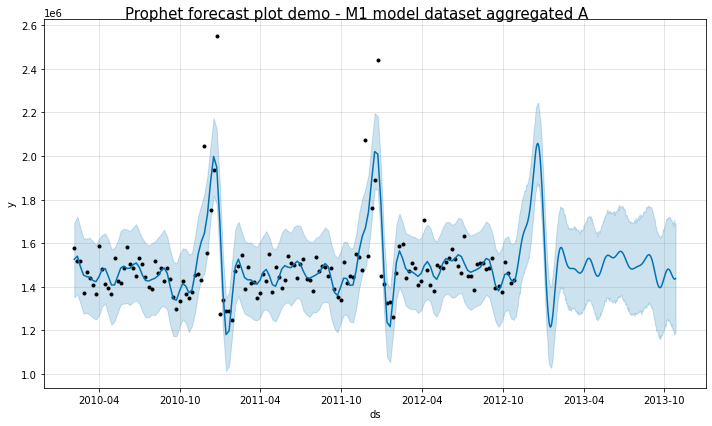

In [24]:
f = s.plot(s.predict(s.make_future_dataframe(periods=365)))
f.suptitle('Prophet forecast plot demo - M1 model dataset aggregated A', size=15)
f.savefig('../plots/plot_demo.pdf')

In [10]:
all_fitted_models.

,model,model_name,dataset_name
0,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp...",m1,aggregated_A
1,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp...",m2,aggregated_A
2,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp...",m3,aggregated_A
3,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp...",m4,aggregated_A
4,"{""growth"": ""linear"", ""n_changepoints"": 1, ""spe...",m5,aggregated_A


In [8]:
data_dates

0     2010-02-05
1     2010-02-12
2     2010-02-19
3     2010-02-26
4     2010-03-05
         ...    
138   2012-09-28
139   2012-10-05
140   2012-10-12
141   2012-10-19
142   2012-10-26
Name: ds, Length: 143, dtype: datetime64[ns]

In [10]:
#sample_loaded_model = all_fitted_models.iloc[0]['model_json']

In [13]:
#sample_loaded_model['params'].keys()

dict_keys(['k', 'm', 'delta', 'sigma_obs', 'beta', 'trend', 'mu', 'log_lik'])

In [14]:
#params = {key: np.array(value) for key, value in sample_loaded_model['params'].items()}

array([[-0.01028589,  0.02567287, -0.02169103, ..., -0.00304187,
        -0.00866277, -0.00316425],
       [ 0.00779504,  0.02906539, -0.02588062, ...,  0.00399647,
        -0.01189045,  0.0122798 ],
       [ 0.00081354,  0.03044364, -0.03105704, ...,  0.00490945,
        -0.00570408, -0.00394943],
       ...,
       [-0.00884106,  0.00623675, -0.02858882, ..., -0.00658596,
        -0.01033644,  0.01173854],
       [-0.00668367,  0.03403291, -0.02527371, ..., -0.00454867,
        -0.01617732,  0.00020192],
       [-0.00147383,  0.01968536, -0.02717291, ...,  0.00664925,
        -0.01629204,  0.00289536]])

## Huomaa tämä
- Muista ladata metriikat / sovelletut metriikat metrics_refactored.py:stä
- Voiko tätä tehdä?? Stan fit sisältää oikean järjestyksen, mutta järjestys menetetään (?) kun katsotaan vain parametreja. 
  Siksi kai stan_backendissa on permuted=False

In [17]:
#sample_loaded_model.growth

AttributeError: 'dict' object has no attribute 'growth'

In [38]:
#from prophet.python.fbprophet.models import StanBackendEnum

In [42]:
#backend = StanBackendEnum.PYSTAN.value

In [43]:
#backend()

prophet.python.fbprophet.models.PyStanBackend

In [39]:
#for i in StanBackendEnum:
#    StanBackendEnum.get_backend_class(i)()

ValueError: Unknown stan backend: StanBackendEnum.PYSTAN

In [32]:
#backend = StanBackendEnum['PYSTAN'].value

In [33]:
#backend()

ModuleNotFoundError: No module named 'fbprophet'

In [44]:
#fbprophet.Prophet()

Importing plotly failed. Interactive plots will not work.


AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [18]:
#some_model = model_from_json(all_fitted_models.iloc[0]['model'])

AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [56]:
# Nyt model on json-model, jolla ei ole muunnettu parametrejä viel mitenkään
def sweep_samples(model, data, warmup=None, metrics = {'aic':aic, 'dic':dic, 'waic':waic}, points = 30):

    
    if warmup is None:
        warmup = model.mcmc_samples//2
    max_samples = model.mcmc_samples - warmup
    fit = model.fit(data, control=fit_kwargs, warmup=warmup)
    og_params = model.params.copy()

    res = pd.DataFrame(columns=metrics.keys())

    def sliced_params(s):
        stan_fit = fit.stan_backend.stan_fit
        ex = stan_fit.extract(permuted=False)[:, :, :-1]
        fn_split = pd.Series(stan_fit.flatnames).apply(lambda x: x.split('[')[0])
        var_names = fn_split.unique()
        params = {}
        for name in var_names:
            reshape_mask = fn_split == name
            reshape_dim = reshape_mask.sum()
            params[name] = ex[:s, :, (fn_split == name).values].reshape((s*4, reshape_dim), order='F')
            np.random.shuffle(params[name])
        return params

    
    for s in np.linspace(max_samples//points, max_samples, points).astype(int):
        row = pd.Series()
        row['samples'] = s
        fit.params = sliced_params(s)
        for metric_name, metric in metrics.items():
            row[metric_name] = metric(fit)
        res = res.append(row, ignore_index=True)
    return res

dict_keys(['k', 'm', 'delta', 'sigma_obs', 'beta', 'trend', 'mu', 'log_lik'])